In [1]:
import numpy as np
import scipy.stats as sps
from tqdm import tqdm
from torchinfo import summary

from utils.utils import *
from utils.noise_gen import *
from utils.training import *
from utils.dataset_loaders import *
from utils.custom_euler_scheduler import CustomEulerDiscreteScheduler
from utils.custom_ddim_scheduler import CustomDDIMScheduler
from utils.custom_ddpm_scheduler import CustomDDPMScheduler
from basic_models import *

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.io import write_video, write_png
from diffusers import (
    UNet3DConditionModel, HeunDiscreteScheduler, EulerDiscreteScheduler, KDPM2DiscreteScheduler,
    LMSDiscreteScheduler
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

/home/jovyan/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/.mlspace/envs/diffusion_noise/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


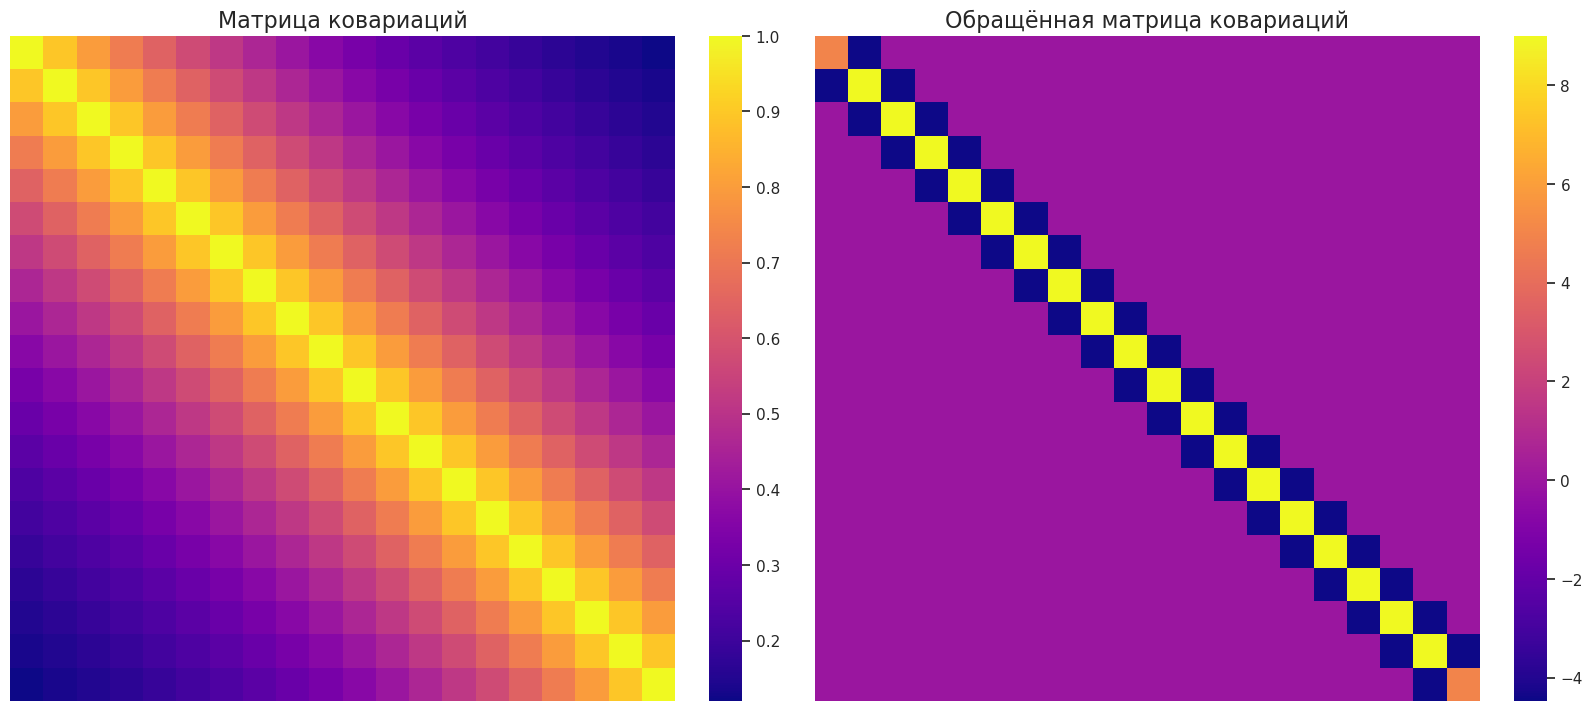

In [12]:
A = progressive_noise(20, alpha=2.0)
B = torch.linalg.inv(A)
maps = (A, B)

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
fig.set_size_inches(16, 7)

for i, a in enumerate(ax):
	sns.heatmap(maps[i], cmap="plasma", ax=a, square=True)
	a.axis("off")

ax[0].set_title("Матрица ковариаций", fontsize=16)
ax[1].set_title("Обращённая матрица ковариаций", fontsize=16)

plt.show()

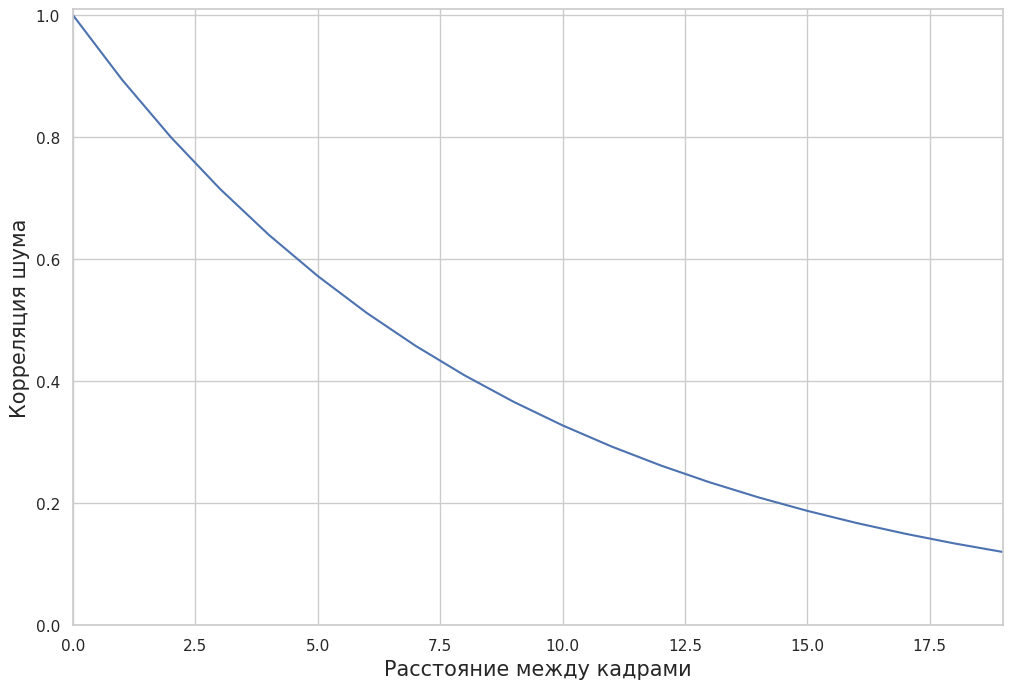

In [7]:
corrs = np.power(2.0/(np.sqrt(1 + 2.0 ** 2)), np.arange(20))

plt.figure(figsize=(12, 8))

plt.plot(np.arange(20), corrs)

plt.xlim(0, 19)
plt.ylim(0, 1.01)

plt.xlabel("Расстояние между кадрами", fontsize=15)
plt.ylabel("Корреляция шума", fontsize=15)

plt.show()

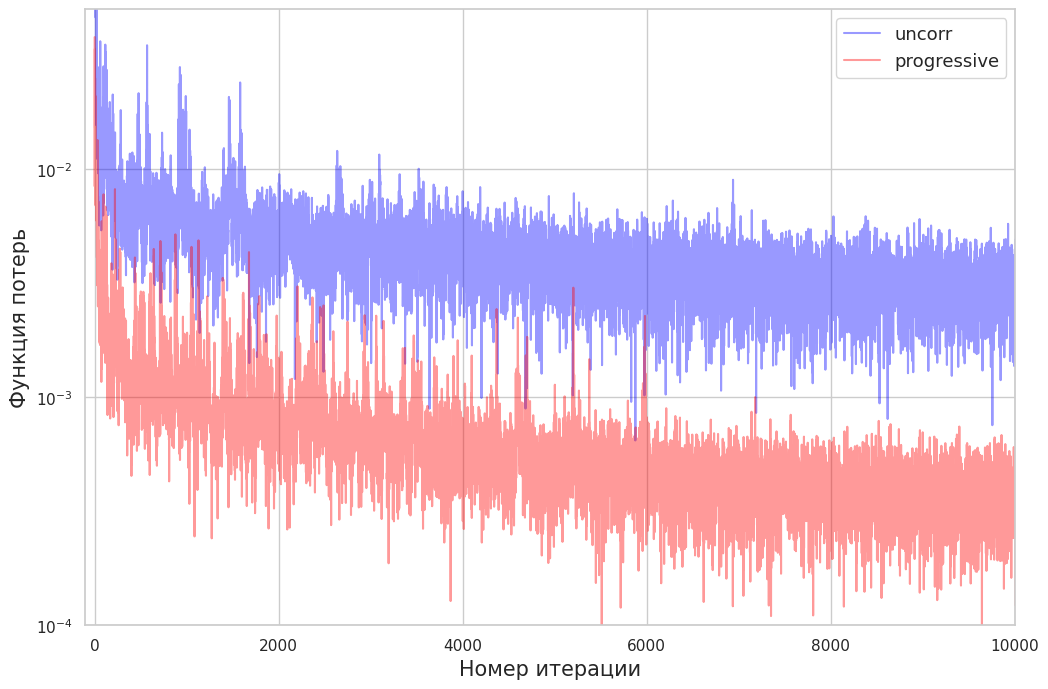

In [14]:
losses_old = torch.load("./models/labeled_mov_mnist/videos/uncorr_noise_slow/losses.pt").numpy().flatten()
losses_new = torch.load("./models/labeled_mov_mnist/videos/slow/losses.pt").numpy().flatten()


plt.figure(figsize=(12, 8))

plt.plot(np.arange(losses_old.shape[0]), losses_old, color="blue", label="uncorr", alpha=0.4)
plt.plot(np.arange(losses_new.shape[0]), losses_new, color="red", label="progressive", alpha=0.4)

plt.xlabel("Номер итерации", fontsize=15)
plt.ylabel("Функция потерь", fontsize=15)

plt.yscale("log")

plt.xlim(-100, 10010)
plt.ylim(1e-4, np.power(10, -1.3))

plt.legend(fontsize=13)
plt.show()

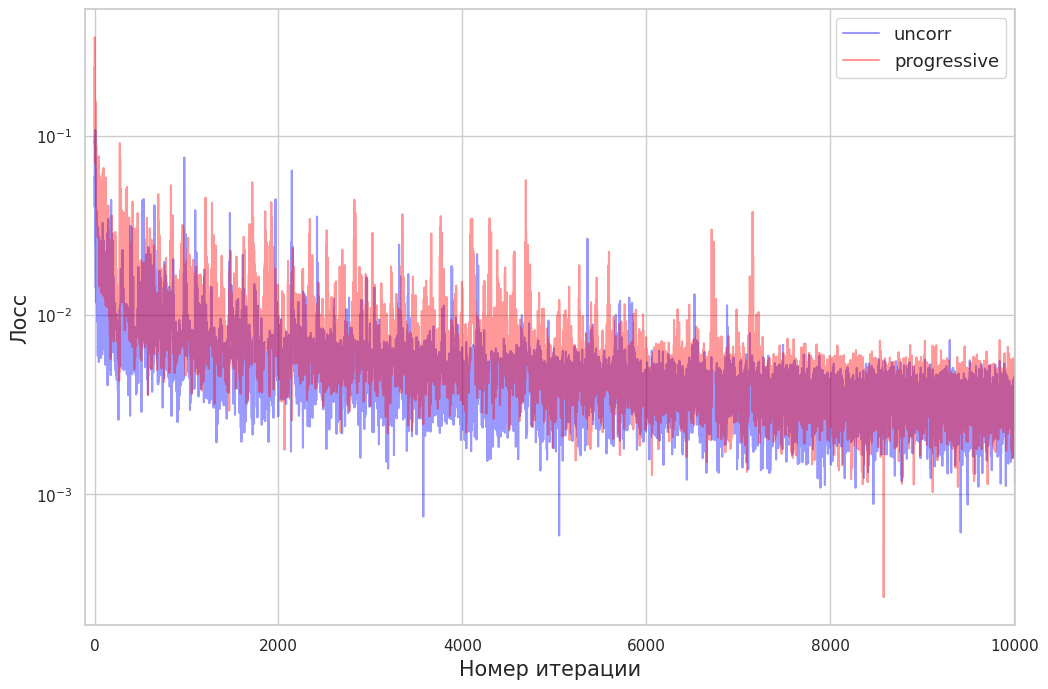

In [13]:
losses_uncorr = torch.load("./models/labeled_mov_mnist/uncorr_noise_1000steps/losses.pt").numpy().flatten()
losses_prog = torch.load("./models/labeled_mov_mnist/prog_noise_1000steps/losses.pt").numpy().flatten()


plt.figure(figsize=(12, 8))

plt.plot(np.arange(losses_uncorr.shape[0]), losses_uncorr, color="blue", label="uncorr", alpha=0.4)
plt.plot(np.arange(losses_prog.shape[0]), losses_prog, color="red", label="progressive", alpha=0.4)

plt.xlabel("Номер итерации", fontsize=15)
plt.ylabel("Лосс", fontsize=15)

plt.yscale("log")

plt.xlim(-100, 10010)

plt.legend(fontsize=13)
plt.show()

In [5]:
sampler.load_state(base_dir_path=f"./models/labeled_mov_mnist/uncorr_noise_1000steps/", suffix="last",
                               load_optimizer=False, load_lr_sched=False, load_ema_model=True)

In [13]:
gen = NormalVideoNoise(cov_matrix=a)
s = gen.sample([1000, 1, 3, 2, 2])

In [15]:
torch.cov(s.permute(2, 0, 1, 3, 4).view(3, -1))

tensor([[0.9858, 0.8821, 0.7921],
        [0.8821, 0.9896, 0.8899],
        [0.7921, 0.8899, 1.0018]])

In [18]:
torch.cov(s.permute(3, 0, 1, 4, 2).reshape(2, -1))

tensor([[0.9856, 0.0360],
        [0.0360, 0.9985]])

In [19]:
torch.cov(s.permute(4, 0, 1, 3, 2).reshape(2, -1))

tensor([[0.9669, 0.0145],
        [0.0145, 1.0173]])

In [24]:
(torch.cov(s.reshape(1000, -1)) - torch.eye(1000)).mean()

tensor(-0.0004)

In [31]:
frames = s.permute(2, 0, 1, 3, 4).view(3, 1000, -1).permute(0, 2, 1)

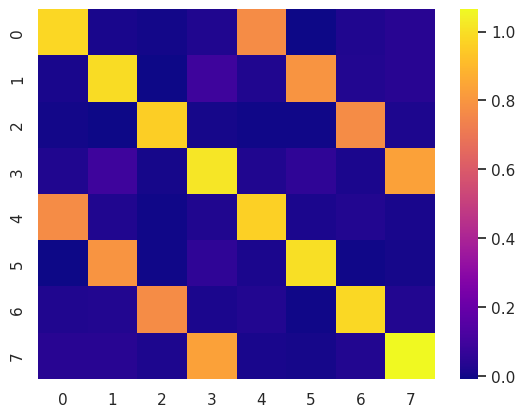

In [37]:
cov0_2 = torch.cov(torch.cat([frames[0], frames[2]], dim=0))

sns.heatmap(cov0_2, cmap="plasma");

Creating dataset and dataloader for UCF-101 and MovingMNIST.

In [17]:
MovMNIST_dataset = MovMNISTDataset("./datasets/moving_mnist_labeled/")
MovMNIST_dataloader = DataLoader(MovMNIST_dataset, shuffle=True, batch_size=14)

dev = "cuda:0"

sampler = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=14,
    total_num_steps=1000,
    beta_start=1e-4, # 1.17e-3
    beta_end=2e-2,   # 1.88e-1
    object_cnt = len(MovMNIST_dataloader),
    device=dev,
    model_type="video",
    use_labels=True,
    cross_att_dim=4,
    noise_cov_matrix = torch.eye(20),
)

e_sch = CustomEulerDiscreteScheduler(
    beta_start=8.5e-4,
    beta_end=1.2e-2,
    beta_schedule="scaled_linear",
    rescale_betas_zero_snr=True,
    noise_cov_matrix=torch.eye(20),
    timestep_spacing="trailing",
)

be_sch = EulerDiscreteScheduler(
    timestep_spacing="trailing",
)

kdpm_sch = KDPM2DiscreteScheduler(
    timestep_spacing="trailing",
)

# heun_sch = HeunDiscreteScheduler(
#     beta_start=8.5e-4,
#     beta_end=1.2e-2,
#     beta_schedule="scaled_linear",
#     clip_sample=False,
#     set_alpha_to_one=False,
#     timestep_spacing="trailing",
# )

lms_sch = LMSDiscreteScheduler(
    timestep_spacing="trailing",
)

ddim_sch = CustomDDIMScheduler(
    beta_start=8.5e-4,
    beta_end=1.2e-2,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    noise_cov_matrix=torch.eye(20),
    timestep_spacing="trailing",
)

In [19]:
MovMNIST_dataset = MovMNISTDataset("./datasets/moving_mnist_labeled_fast/")
MovMNIST_dataloader = DataLoader(MovMNIST_dataset, shuffle=True, batch_size=14)

trainer_video = init_mov_mnist_model(
	lr_warmup_steps=100,
	num_epochs=14,
	total_num_steps=100,
	beta_start=1.17e-3, # 1.17e-3
	beta_end=1.88e-1,   # 1.88e-1
	object_cnt = len(MovMNIST_dataloader),
	device="cuda:0",
	model_type="video",
	use_labels=True,
	cross_att_dim=4,
	noise_cov_matrix = torch.eye(20),
)

summary(trainer_video.model_ref)

Layer (type:depth-idx)                                                 Param #
MovMNISTModel                                                          --
├─UNet3DConditionModel: 1-1                                            --
│    └─Conv2d: 2-1                                                     320
│    └─Timesteps: 2-2                                                  --
│    └─TimestepEmbedding: 2-3                                          --
│    │    └─Linear: 3-1                                                4,224
│    │    └─SiLU: 3-2                                                  --
│    │    └─Linear: 3-3                                                16,512
│    └─TransformerTemporalModel: 2-4                                   --
│    │    └─GroupNorm: 3-4                                             64
│    │    └─Linear: 3-5                                                1,056
│    │    └─ModuleList: 3-6                                            21,024
│    │    └─Linear

In [18]:
for noise_name, model_path, noise_cov in zip(
    ("uncorr", "prog"),
    ("uncorr_noise_1000steps", "prog_noise_1000steps"),
    (torch.eye, progressive_noise),
):
    for sch_name, sch in zip(
        ("Euler2",),
        (e_sch,),
    ):
        for num_steps in (5, 10, 20, 50):
            # sample_corr = torch.load("./sample_corr_matrix.pt", map_location="cpu").float()
            sampler.load_state(base_dir_path=f"./models/labeled_mov_mnist/{model_path}/", suffix="last",
                               load_optimizer=False, load_lr_sched=False, load_ema_model=True)
            sampler.EMA_model.cross_att_dim = 4
            sampler.EMA_model.need_time_embs = False
            objects = sampler.sample(num_samples=8,
                                     video_length=20,
                                     prompts = torch.tensor([1, 11, 27, 54, 32, 45, 48, 23]),
        #                              override_noise_cov=lambda x: progressive_noise(x),
                                     override_noise_cov = lambda x: noise_cov(x),
                                     num_inference_steps = num_steps,
                                     override_noise_scheduler = sch,
                                    )

            for i, v in enumerate(objects):
                write_video(
                    f"./results/MovMNIST/scheduler_comparison_1000steps/{sch_name}_{num_steps}_{noise_name}_noise_{i}.mp4",
                    v.repeat(3, 1, 1, 1).permute(1, 2, 3, 0),
                    fps=7,
                )

100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


In [10]:
for i, v in enumerate(objects):
    write_video(
        f"./results/MovMNIST/test/100_prog_noise{i}.mp4",
        v.repeat(3, 1, 1, 1).permute(1, 2, 3, 0),
        fps=7,
    )

In [2]:
from torchvision.io import read_video

def _load_folder(path, device="cpu"):
	video_names = listdir(path)
	
	saved_videos = []
	for p in tqdm(video_names):
		v, _, _ = read_video(join(path, p), pts_unit="sec")
		saved_videos.append(v)
	ret_videos = torch.stack(saved_videos).permute(0, 1, 4, 2, 3).to(device) # Делаем B T C H W

	return ret_videos

prog_noise_videos = _load_folder("./generation_comparison/prog_noise")
uncorr_noise_videos = _load_folder("./generation_comparison/uncorr_noise")

100%|██████████| 1000/1000 [00:16<00:00, 59.46it/s]


In [3]:
prog_noise_diff = prog_noise_videos[:, 1:].float() - prog_noise_videos[:, :-1].float()
uncorr_noise_diff = uncorr_noise_videos[:, 1:].float() - uncorr_noise_videos[:, :-1].float()

prog_noise_rmse = torch.sqrt((prog_noise_diff * prog_noise_diff).mean())
uncorr_noise_rmse = torch.sqrt((uncorr_noise_diff * uncorr_noise_diff).mean())

prog_noise_mae = torch.abs(prog_noise_diff).mean()
uncorr_noise_mae = torch.abs(uncorr_noise_diff).mean()

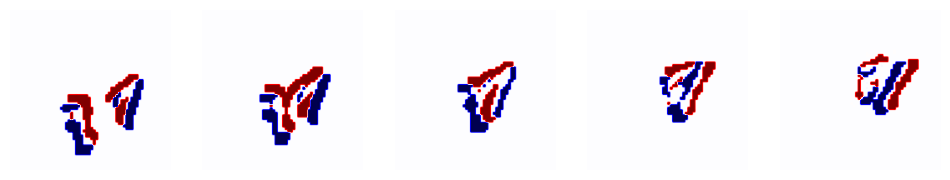

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(12, 8)

for i in range(5):
	ax[i].imshow(((uncorr_noise_diff[9, i, [0]].permute(1, 2, 0) + 255) / 2).to(torch.uint8), cmap="seismic")
	ax[i].axis("off")

plt.show()

In [12]:
(prog_noise_videos[9, i, [0]].float() / (255 * 2) + prog_noise_videos[9, i+1, [0]].float() / (255 * 2)).max()

tensor(0.9961)

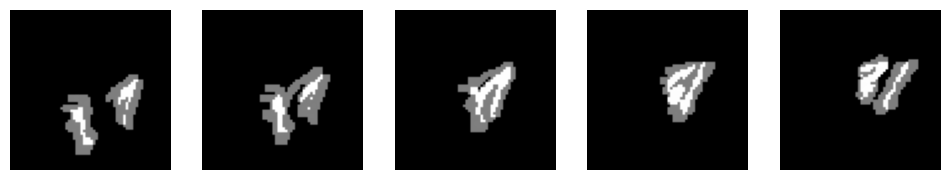

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(12, 8)

for i in range(5):
	ax[i].imshow((((uncorr_noise_videos[9, i, [0]].float() / (255 * 2) + uncorr_noise_videos[9, i+1, [0]].float() / (255 * 2)).permute(1, 2, 0) * 255) / 1).to(torch.uint8), cmap="grey")
	ax[i].axis("off")

plt.show()

In [24]:
torch.minimum((uncorr_noise_videos[9, i, [0]].float() / (255 * 2) + uncorr_noise_videos[9, i+1, [0]].float() / (255 * 1)).permute(1, 2, 0) * 255, torch.tensor([1.0])).max()

tensor(1.)

In [25]:
(uncorr_noise_videos[9, i, [0]].float() / (255 * 2)).max()

tensor(0.5000)

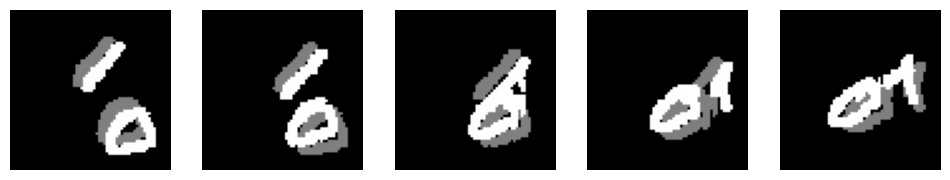

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(12, 8)

num_vid = 42

for i in range(5):
	ax[i].imshow(torch.minimum((uncorr_noise_videos[num_vid, i, [0]].float() / (255 * 2) + uncorr_noise_videos[num_vid, i+1, [0]].float() / (255 * 1)).permute(1, 2, 0), torch.tensor([1.0])), cmap="grey")
	ax[i].axis("off")

plt.show()

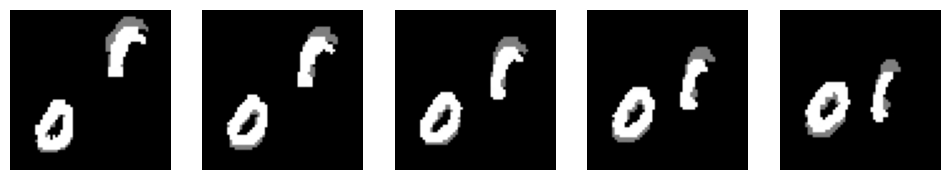

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(12, 8)

num_vid = 12

for i in range(5):
	ax[i].imshow(torch.minimum((prog_noise_videos[num_vid, i, [0]].float() / (255 * 2) + prog_noise_videos[num_vid, i+1, [0]].float() / (255 * 1)).permute(1, 2, 0), torch.tensor([1.0])), cmap="grey")
	ax[i].axis("off")

plt.show()

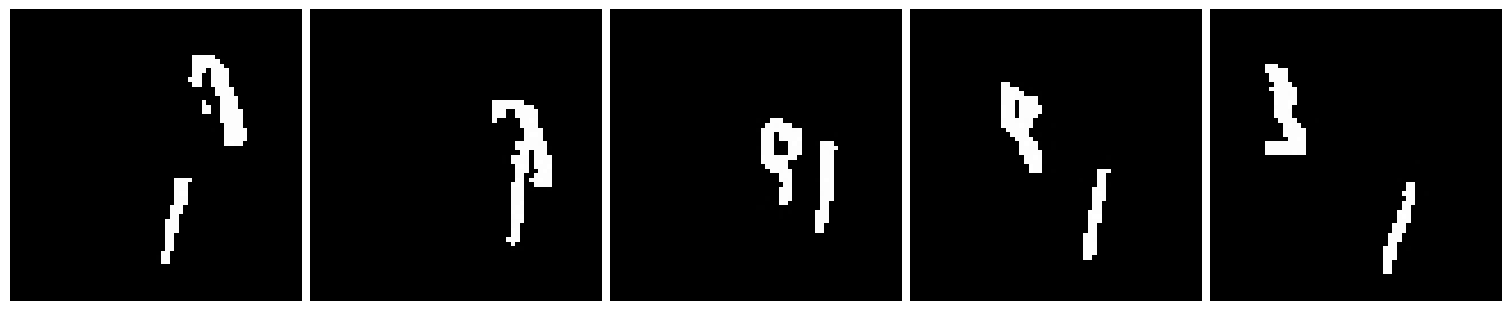

In [13]:
from torchvision.io import read_video

vid, _, _ = read_video("./generation_comparison/uncorr_noise/_13.mp4", pts_unit="sec")

parts = 5
step = 20 // 5

fig, ax = plt.subplots(nrows=1, ncols=5, constrained_layout=True)
fig.set_size_inches(15, 3)

for i, a in enumerate(ax):
    a.imshow(vid[i * step])
    a.axis("off")

plt.show()

  0%|                                                                                                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.16it/s]


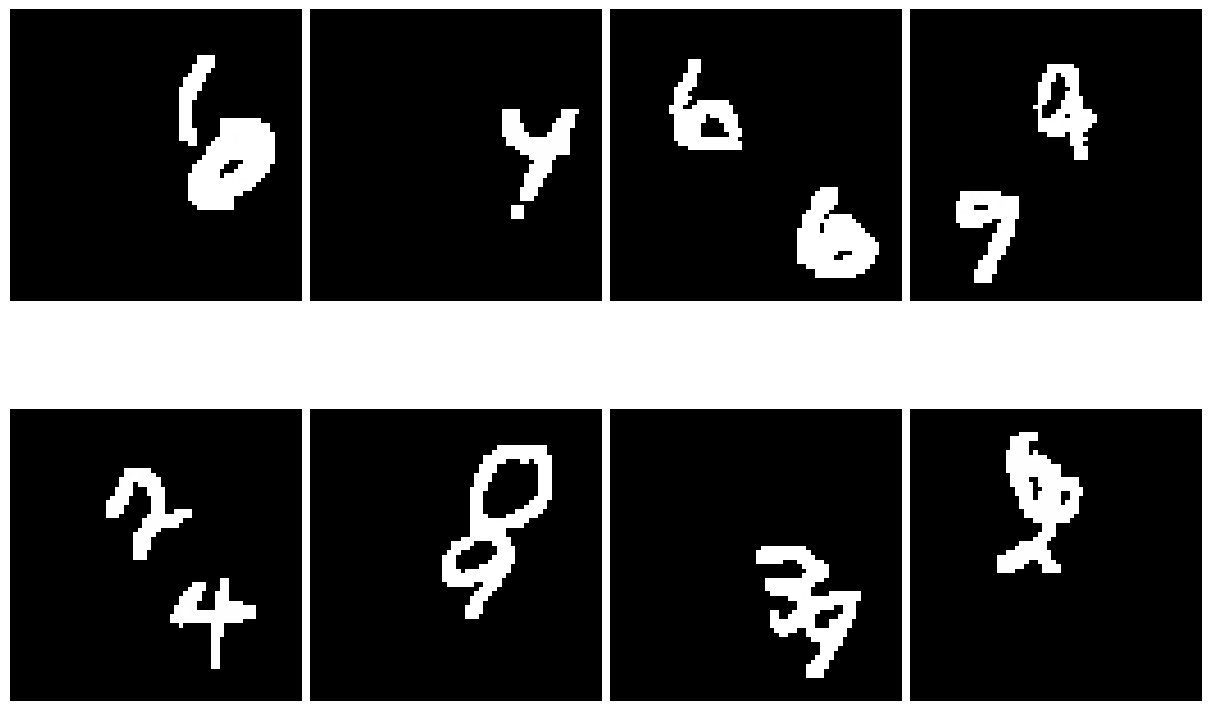

In [4]:
images = sampler.sample(num_samples=8, prompts = torch.tensor([1, 11, 27, 54, 32, 45, 48, 23]))
# images = a.sample.detach().cpu()
# images = ((images.clip(-1, 1) + 1) / 2 * 255).to(torch.uint8)

fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True)
fig.set_size_inches(12, 8)

for i, im in enumerate(images):
    ax[i // 4][i % 4].imshow(im.permute(1, 2, 0), cmap="grey")
    ax[i // 4][i % 4].axis("off")

plt.show()

In [5]:
for i, im in enumerate(images):
    write_png(im, f"results/MovMNIST/labeled_frames/_{i}.png")